In [10]:
"""
Laplacian Eigenmaps from Swiss roll demo

Requirements:
- numpy
- scipy
- scikit-learn
- matplotlib
"""

import numpy as np
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding

In [2]:
def build_knn_graph(X, n_neighbors=10):
    """
    Build a symmetric k-NN graph.

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Input data.
    n_neighbors : int
        Number of nearest neighbors (k).

    Returns
    -------
    distances : csr_matrix, shape (n_samples, n_samples)
        Sparse matrix of pairwise distances for neighbor pairs only.
    indices : csr_matrix (same structure as distances)
        Boolean/sparse 1 where neighbor relation exists, 0 otherwise.
    """
    n_samples = X.shape[0]

    # Use sklearn to find k nearest neighbors (excluding self)
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')
    nn.fit(X)
    distances, neighbors = nn.kneighbors(X)

    # neighbors[i, 0] is the point itself (distance 0), so we skip index 0
    rows = []
    cols = []
    vals = []

    for i in range(n_samples):
        for j_idx in range(1, n_neighbors + 1):
            j = neighbors[i, j_idx]
            d = distances[i, j_idx]
            rows.append(i)
            cols.append(j)
            vals.append(d)

    # Build directed kNN graph first
    distances_directed = sp.csr_matrix(
        (vals, (rows, cols)),
        shape=(n_samples, n_samples)
    )

    # Symmetrize: if i is neighbor of j OR j is neighbor of i, connect them
    # For distances, we can take the minimum
    distances_sym = distances_directed.minimum(distances_directed.T)

    # Binary adjacency indices (where edge exists)
    adjacency = distances_sym.copy()
    adjacency.data[:] = 1.0

    return distances_sym, adjacency


def build_weight_matrix(distances, t=None):
    """
    Build weight matrix W from distances using either:
    - binary weights (if t is None)
    - heat kernel weights (if t is not None)

    Parameters
    ----------
    distances : csr_matrix, shape (n_samples, n_samples)
        Pairwise distances for neighbor pairs.
    t : float or None
        Heat kernel parameter. If None, use binary weights.

    Returns
    -------
    W : csr_matrix, shape (n_samples, n_samples)
        Symmetric weight matrix.
    """
    if t is None:
        # Binary weights: W_ij = 1 if edge exists
        W = distances.copy()
        W.data[:] = 1.0
    else:
        # Heat kernel weights: W_ij = exp(-||xi - xj||^2 / t)
        W = distances.copy()
        # distances.data contains ||xi - xj||
        W.data = np.exp(-(W.data ** 2) / t)

    return W


def build_laplacian(W, normalized=False):
    """
    Build graph Laplacian L from weight matrix W.

    Parameters
    ----------
    W : csr_matrix, shape (n_samples, n_samples)
        Weight matrix.
    normalized : bool
        If False: return unnormalized Laplacian L = D - W
        If True:  return symmetric normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}

    Returns
    -------
    L : csr_matrix
        Laplacian matrix.
    D : csr_matrix
        Degree matrix.
    """
    n_samples = W.shape[0]
    # Degree: D_ii = sum_j W_ij
    degrees = np.array(W.sum(axis=1)).ravel()
    D = sp.diags(degrees, 0)

    if not normalized:
        L = D - W
        return L, D
    else:
        # D^{-1/2}
        with np.errstate(divide='ignore'):
            d_inv_sqrt = 1.0 / np.sqrt(degrees)
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
        D_inv_sqrt = sp.diags(d_inv_sqrt, 0)

        # L_sym = I - D^{-1/2} W D^{-1/2}
        I = sp.identity(n_samples, format='csr')
        L_sym = I - D_inv_sqrt @ W @ D_inv_sqrt
        return L_sym, D  # we still return D for convenience


def laplacian_eigenmaps(
    X,
    n_components=2,
    n_neighbors=10,
    t=None,
    normalized=False,
    random_state=0
):
    """
    Perform Laplacian Eigenmaps embedding.

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Input data.
    n_components : int
        Dimension of the embedding.
    n_neighbors : int
        Number of neighbors for kNN graph.
    t : float or None
        Heat kernel parameter (if None, use binary weights).
    normalized : bool
        If False, use unnormalized Laplacian and generalized eigenproblem:
            L f = lambda D f
        If True, use symmetric normalized Laplacian and standard eigenproblem:
            L_sym v = lambda v
    random_state : int
        Seed for reproducibility (used in eigsh).

    Returns
    -------
    Y : array, shape (n_samples, n_components)
        Embedded coordinates.
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]

    # 1. Build kNN graph
    distances, adjacency = build_knn_graph(X, n_neighbors=n_neighbors)

    # 2. Build weight matrix W
    W = build_weight_matrix(distances, t=t)

    # 3. Build Laplacian
    L, D = build_laplacian(W, normalized=normalized)

    # 4. Solve eigenproblem
    # We want the smallest (non-trivial) eigenvalues:
    # - if unnormalized: L f = lambda D f (generalized)
    # - if normalized:   L_sym v = lambda v
    k = n_components + 1  # +1 to skip the trivial eigenvector

    if not normalized:
        # Generalized eigenproblem: L f = lambda D f
        # We use eigsh with M=D and sigma=0 to get smallest eigenvalues near 0.
        # Make sure D is positive-definite (no isolated nodes).
        # eigsh returns eigenvalues in ascending order.
        vals, vecs = eigsh(
            L,
            k=k,
            M=D,
            sigma=0.0,
            which='LM'
        )
    else:
        # Standard symmetric eigenproblem: L_sym v = lambda v
        vals, vecs = eigsh(
            L,
            k=k,
            sigma=0.0,
            which='LM'
        )

    # Sort eigenvalues/eigenvectors (they should already be sorted, but be safe)
    idx = np.argsort(vals)
    vals = vals[idx]
    vecs = vecs[:, idx]

    # Skip the first eigenvector (eigenvalue ≈ 0, constant)
    embedding = vecs[:, 1:k]

    return embedding

In [3]:
# -------------------------------------------------------------------------
# Swiss Roll Demo
# -------------------------------------------------------------------------
# 1. Generate Swiss roll data
n_samples = 2000
X, color = make_swiss_roll(n_samples=n_samples, noise=0.0)

In [4]:
# 2. Run Laplacian Eigenmaps
n_components = 2
n_neighbors = 10
t = None  # set e.g. t=5.0 for heat kernel weighting, None for binary

Y = laplacian_eigenmaps(
    X,
    n_components=n_components,
    n_neighbors=n_neighbors,
    t=t,
    normalized=False,
    random_state=0
)

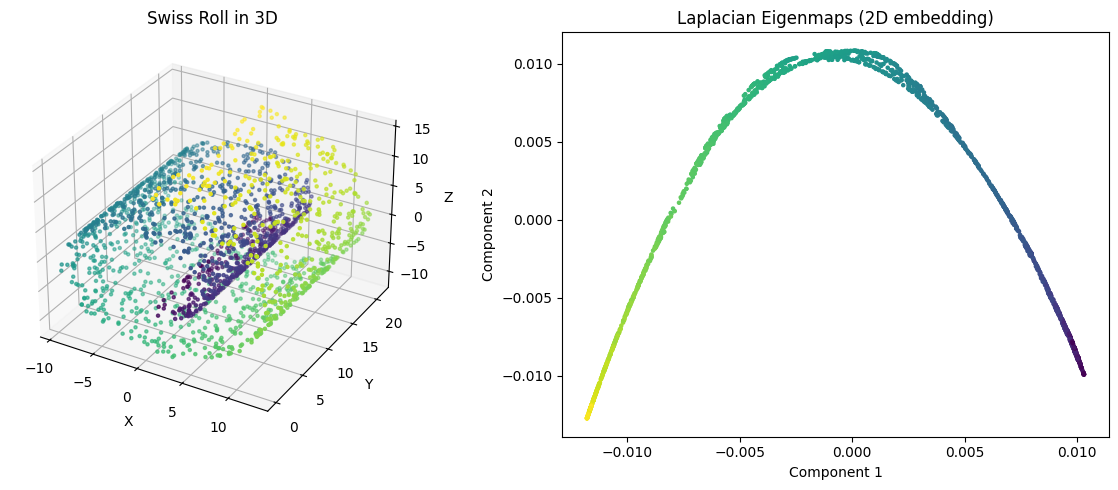

In [5]:
# 3. Plot results

# (a) Original Swiss roll in 3D
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, s=5)
ax.set_title("Swiss Roll in 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# (b) 2D Laplacian Eigenmaps embedding
ax2 = fig.add_subplot(1, 2, 2)
sc = ax2.scatter(Y[:, 0], Y[:, 1], c=color, s=5)
ax2.set_title("Laplacian Eigenmaps (2D embedding)")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

In [8]:
t = 5.0
n_neighbors = 15 # more global
# or 10.0, 25.0, etc.
Y = laplacian_eigenmaps(
    X,
    n_components=n_components,
    n_neighbors=n_neighbors,
    t=t,
    normalized=False,
    random_state=0
)

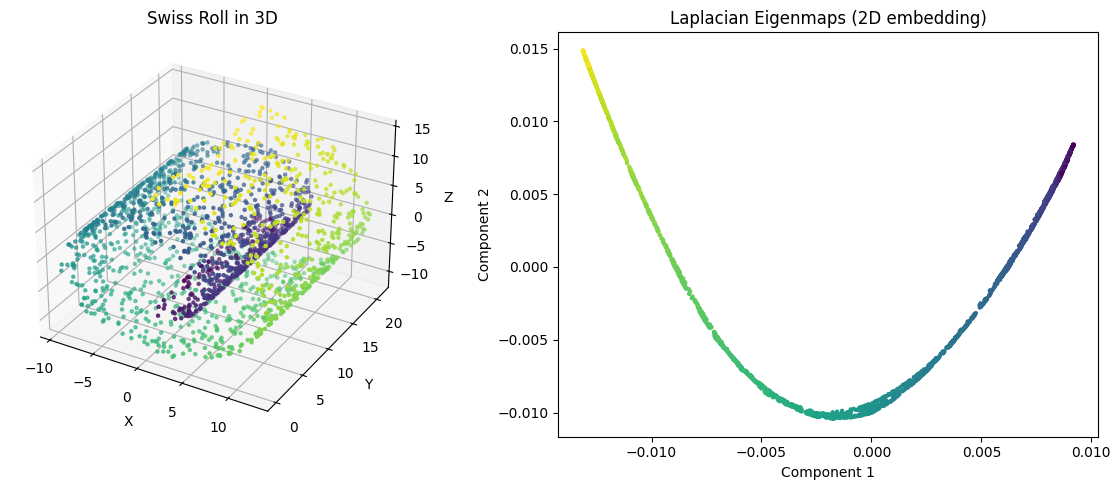

In [9]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, s=5)
ax.set_title("Swiss Roll in 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# (b) 2D Laplacian Eigenmaps embedding
ax2 = fig.add_subplot(1, 2, 2)
sc = ax2.scatter(Y[:, 0], Y[:, 1], c=color, s=5)
ax2.set_title("Laplacian Eigenmaps (2D embedding)")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

# sklearn version

In [12]:
def laplacian_eigenmaps_sklearn(
    X,
    n_components=2,
    n_neighbors=10,
    t=None,
    random_state=0
):
    """
    Laplacian Eigenmaps using sklearn's SpectralEmbedding.

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Input data.
    n_components : int
        Dimension of the embedding.
    n_neighbors : int
        Number of neighbors for the kNN graph.
    t : float or None
        Heat kernel parameter. If None, use 'nearest_neighbors' affinity.
        If not None, use 'rbf' affinity with gamma = 1 / t.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    Y : array, shape (n_samples, n_components)
        Embedded coordinates.
    """
    if t is None:
        # kNN graph + binary weights (Laplacian Eigenmaps style)
        embedding = SpectralEmbedding(
            n_components=n_components,
            n_neighbors=n_neighbors,
            affinity="nearest_neighbors",
            random_state=random_state,
        )
    else:
        # Heat kernel (RBF) weights
        # sklearn uses exp(-gamma * ||x_i - x_j||^2)
        # the paper uses exp(-||x_i - x_j||^2 / t) => gamma = 1/t
        gamma = 1.0 / float(t)
        embedding = SpectralEmbedding(
            n_components=n_components,
            affinity="rbf",
            gamma=gamma,
            random_state=random_state,
        )

    Y = embedding.fit_transform(X)
    return Y

In [13]:
# 2. Run Laplacian Eigenmaps via sklearn
n_components = 2
n_neighbors = 10

# Option 1: binary kNN weights (closest to t = ∞ in the paper)
Y_nn = laplacian_eigenmaps_sklearn(
    X,
    n_components=n_components,
    n_neighbors=n_neighbors,
    t=None,          # nearest_neighbors affinity
    random_state=0
)

# Option 2: heat kernel weights (RBF)
t = 5.0
Y_rbf = laplacian_eigenmaps_sklearn(
    X,
    n_components=n_components,
    n_neighbors=n_neighbors,  # ignored when affinity="rbf"
    t=t,                      # uses gamma = 1/t
    random_state=0
)

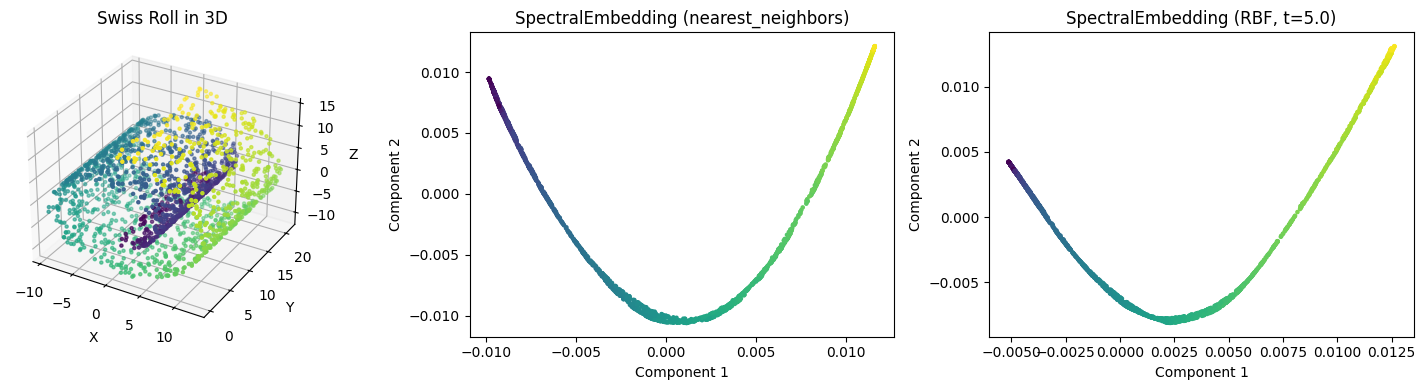

In [14]:
# 3. Plot results

fig = plt.figure(figsize=(15, 4))

# (a) Original Swiss roll in 3D
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, s=5)
ax.set_title("Swiss Roll in 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# (b) 2D embedding - nearest_neighbors
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(Y_nn[:, 0], Y_nn[:, 1], c=color, s=5)
ax2.set_title("SpectralEmbedding (nearest_neighbors)")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

# (c) 2D embedding - RBF / heat kernel
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(Y_rbf[:, 0], Y_rbf[:, 1], c=color, s=5)
ax3.set_title(f"SpectralEmbedding (RBF, t={t})")
ax3.set_xlabel("Component 1")
ax3.set_ylabel("Component 2")

plt.tight_layout()
plt.show()